In [1]:
# Import the necessary packages
import numpy as np
import random
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt

In [2]:
random.seed(3)

In [3]:
# Read in the data
def stockData(stockList):
    iteration = 0
    for stocks in stockList:
        match iteration:
            case 0:
                stockDf=dd.read_csv(f'{stocks}.csv', parse_dates=['Date'], infer_datetime_format=True).set_index('Date')
                iteration = 1
                pass
            case 1:
                stockDf[stocks]=dd.read_csv(f'{stocks}.csv', parse_dates=['Date'], infer_datetime_format=True).set_index('Date')['Close']
                stockDf[stockList[0]] = stockDf['Close']
                stockDf = stockDf.loc[:, stockList[:2]]
                iteration = 2
                pass
            case 2:
                stockDf[stocks]=dd.read_csv(f'{stocks}.csv', parse_dates=['Date'], infer_datetime_format=True).set_index('Date')['Close']
                pass
        pass
    if len(stockList)<2:
        stockDf[stockList[0]] = stockDf['Close']
        return stockDf[stockList[0]]
        pass
    else:
        return stockDf

In [4]:
# Transform data to %Change returns
@dask.delayed
def pctChange(stockDf):
    for eachCol in stockDf:
      stockDf[eachCol] = stockDf[eachCol]/stockDf[eachCol].shift()-1
      pass
    return stockDf.dropna()

In [5]:
#Define the scale data function
@dask.delayed
def scaleData(data, portfolioProportions):
    # Scale the data
    scaledData = data.copy()
    for eachStock in scaledData:
        scaledData[eachStock] = data[eachStock] * portfolioProportions[eachStock]
        pass
    return scaledData

In [6]:
# Calculate the average return of the portfolio
# Removed @dask.delayed
def averageReturn(scaledData):
    return scaledData.sum(axis=1).mean()

In [7]:
# Calculate the risk of the portfolio
# Removed @dask.delayed
def expectedRisk(scaledData):
    return scaledData.sum(axis=1).std()

In [8]:
# Analyze the risk and return of 20 random portfolios in the stock list
def portfolioAnalysis(stockList, randomPortfolios=500):
    # Read in the data
    # Changed () around function including (parameters) for dask.delayed
    data = dask.delayed(pctChange(stockData(stockList)))
    # Make an empty list of empty dictionaries
    portfolioProportions = [{} for i in range(randomPortfolios)]
    averageReturns = []
    expectedRisks = []
    # Make 20 random portfolios from the stock list
    for portfolios in range(0,randomPortfolios):
        remainder = 1.0
        for eachStock in stockList[:-1]:
            proportion = round(random.uniform(0,remainder-.01),2)
            portfolioProportions[portfolios][eachStock] = proportion
            remainder = remainder - proportion
            pass
        portfolioProportions[portfolios][stockList[-1]] = round(remainder,2)
        pass
        # Scale the data based on the portfolio proportions
        scaledData = dask.delayed(scaleData)(data, portfolioProportions[portfolios])
        # Get average return and risk for each portfolio
        # Removed dask.delayed
        averageReturns.append(averageReturn(scaledData).compute())
        expectedRisks.append(expectedRisk(scaledData))
        pass
    # Moved averageReturns compute into the for loop
    # averageReturns = dask.compute(*averageReturns)
    expectedRisks = dask.compute(*expectedRisks)
    return averageReturns, expectedRisks, portfolioProportions, stockList

In [9]:
# Plot the risk and return of the portfolios
def plotPortfolios(portfolioAnalysis):
    # Plot the risk and return of the portfolios
    plt.figure(figsize=(8,6))
    plt.scatter(portfolioAnalysis[1], portfolioAnalysis[0], s=100, c='blue')
    plt.xlabel('Risk')
    plt.ylabel('Average Return')
    for eachPortfolioIndex in range(len(portfolioAnalysis[2])):
        plt.annotate([f'{eachStock}: {portfolioAnalysis[2][eachPortfolioIndex][eachStock]}' for eachStock in portfolioAnalysis[3]], (portfolioAnalysis[1][eachPortfolioIndex], portfolioAnalysis[0][eachPortfolioIndex]))
    plt.show()
    pass

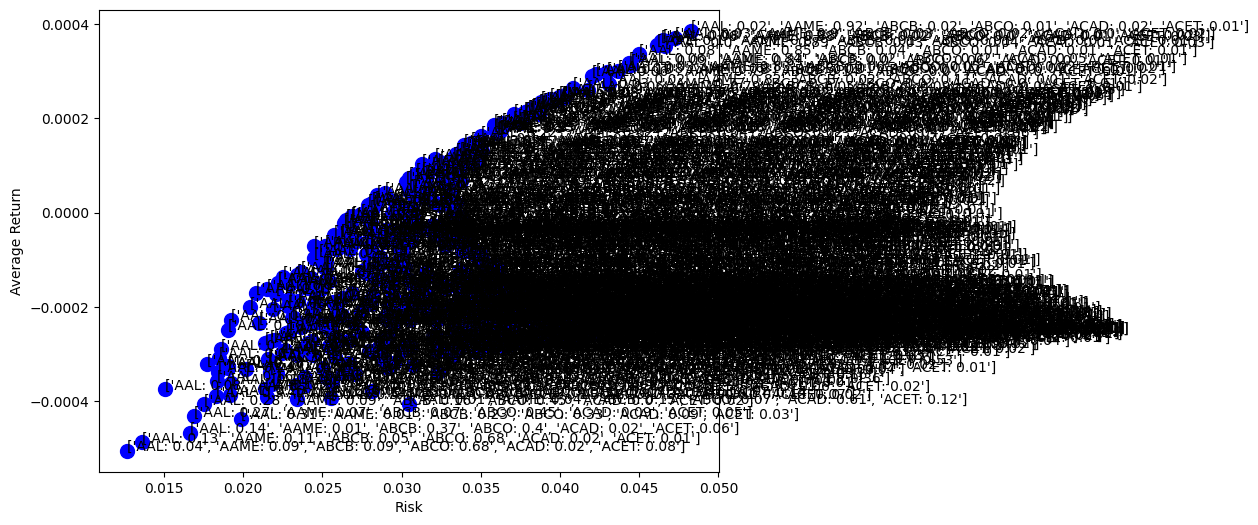

In [10]:
plotPortfolios(portfolioAnalysis(['AAL','AAME', 'ABCB', 'ABCO', 'ACAD', 'ACET']))